# Maquette python du traitement des données Resting State du dataset ScalingTime

In [1]:
%matplotlib inline

In [2]:
import matplotlib.pyplot as plt

In [3]:
import seaborn as sns

In [4]:
sns.set(style="darkgrid")

To debug notebooks:
```
from IPython.core.debugger import Pdb; Pdb().set_trace()
```

In [5]:
!pip install -e ~/Multifracs/mfanalysis

Obtaining file:///volatile/dumeur/Multifracs/mfanalysis
  Found existing installation: mfanalysis 0.15.dev0
    Uninstalling mfanalysis-0.15.dev0:
      Successfully uninstalled mfanalysis-0.15.dev0
  Running setup.py develop for mfanalysis


## Get data

In [6]:
dossier = '/volatile/MEG_data_scalingTime/RSdata_cleanedICA/'

fichier1 = 'ag170045_ScaledTime_RS01_MF_crop_ica_sss_raw.fif'

In [7]:
import mne

In [8]:
raw = mne.io.read_raw_fif(dossier+fichier1)

Opening raw data file /volatile/MEG_data_scalingTime/RSdata_cleanedICA/ag170045_ScaledTime_RS01_MF_crop_ica_sss_raw.fif...
    Range : 1264365 ... 1333499 =    632.183 ...   666.750 secs
Ready.
Current compensation grade : 0


In [9]:
fs = raw.info['sfreq']

In [10]:
raw.load_data()

Reading 0 ... 69134  =      0.000 ...    34.567 secs...


<Raw  |  ag170045_ScaledTime_RS01_MF_crop_ica_sss_raw.fif, n_channels x n_times : 340 x 69135 (34.6 sec), ~187.1 MB, data loaded>

## Select time series

In [11]:
sensor = 'MEG2133'
sensor in raw.ch_names

True

In [12]:
raw.pick_channels([sensor])

<Raw  |  ag170045_ScaledTime_RS01_MF_crop_ica_sss_raw.fif, n_channels x n_times : 1 x 69135 (34.6 sec), ~7.7 MB, data loaded>

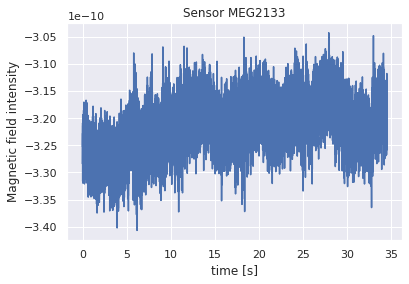

In [13]:
plt.plot(raw[0][1], raw[0][0][0])
plt.title(f'Sensor {sensor}')
plt.xlabel('time [s]')
plt.ylabel('Magnetic field intensity')
plt.show()

## Compute scale frequency relation

In [14]:
import numpy as np

In [15]:
jj = np.arange(1,16)

FjDo = fs*np.array([np.power(2.0,-j) for j in jj])
Fj = 3/4*FjDo
FjUp = 1/2*FjDo

In [16]:
Fj

array([7.50000000e+02, 3.75000000e+02, 1.87500000e+02, 9.37500000e+01,
       4.68750000e+01, 2.34375000e+01, 1.17187500e+01, 5.85937500e+00,
       2.92968750e+00, 1.46484375e+00, 7.32421875e-01, 3.66210938e-01,
       1.83105469e-01, 9.15527344e-02, 4.57763672e-02])

In [17]:
FjDo

array([1.00000000e+03, 5.00000000e+02, 2.50000000e+02, 1.25000000e+02,
       6.25000000e+01, 3.12500000e+01, 1.56250000e+01, 7.81250000e+00,
       3.90625000e+00, 1.95312500e+00, 9.76562500e-01, 4.88281250e-01,
       2.44140625e-01, 1.22070312e-01, 6.10351562e-02])

In [18]:
FjUp

array([5.00000000e+02, 2.50000000e+02, 1.25000000e+02, 6.25000000e+01,
       3.12500000e+01, 1.56250000e+01, 7.81250000e+00, 3.90625000e+00,
       1.95312500e+00, 9.76562500e-01, 4.88281250e-01, 2.44140625e-01,
       1.22070312e-01, 6.10351562e-02, 3.05175781e-02])

## Second order Fourier-Wavelet analysis

In [19]:
data = raw[0][0][0]

In [20]:
data -= data.mean()
data /= data.std()

In [21]:
overlapingratio = 4
window_size = np.power(2, np.fix(np.log2(len(data))) - overlapingratio)

In [22]:
from mfanalysis.psd import plot_psd

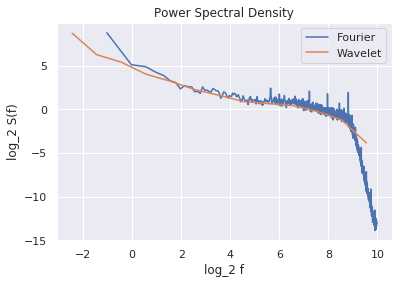

In [23]:
plot_psd(data, fs, segment_size=window_size)

## Second order Wavelet analysis using MF toolbox

In [24]:
import mfanalysis as mf

In [25]:
from importlib import reload

In [26]:
mf = reload(mf)

In [27]:
nwt = 2

In [28]:
mfa = mf.MFA(
    wt_name=f'db{nwt}',
    formalism='wcmf',
    j1=10,j2=14,
    q=np.arange(-2,3),
    n_cumul=2,
    gamint=1/2,
    wtype=0
)

In [29]:
mfa.analyze(data)

 
(!) Warning: Value of j2 is higher than the maximum            allowed level. Max level and j2 set to 13
 


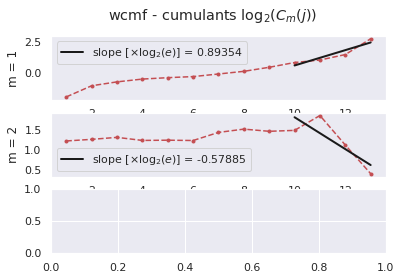

In [30]:
mfa.plot_cumulants()

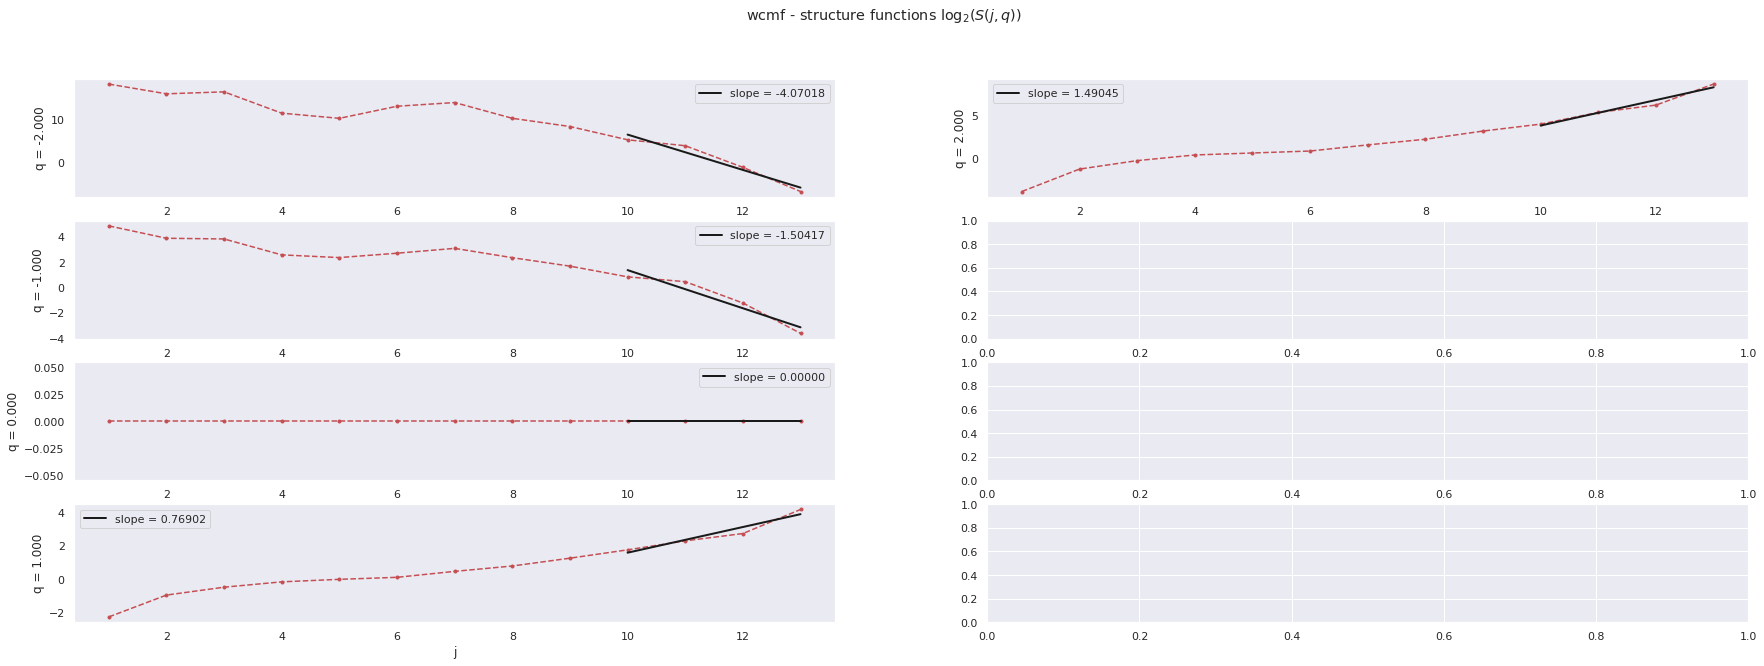

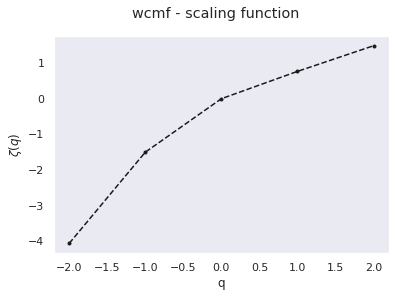

In [31]:
mfa.plot_structure()

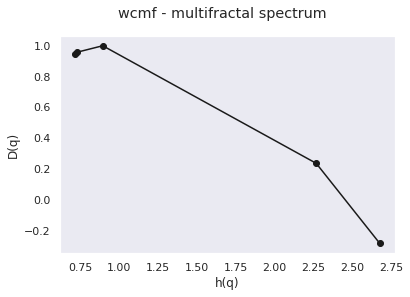

In [32]:
mfa.plot_spectrum()

### Comparing results

Values are found in the logstat variable, optionally output by the MF_BS_tool `analyze` method call

The matrix of interest is logstat.('DWT').est ; the moments are found in the first 4 rows, whereas the cumulants are the last two

**Moments**

In [33]:
logmoment_matlab = np.genfromtxt(fname="MATLAB_values/logscale_moment_DWT.tsv", delimiter="\t", skip_header=0, filling_values=1)

OSError: MATLAB_values/logscale_moment_DWT.tsv not found.

In [ ]:
logmoment_python = mfa.structure.logvalues

In [ ]:
(np.abs(logmoment_matlab - logmoment_python) < 2.1e-5).all()

**Cumulants**

In [ ]:
logcumulant_matlab = np.genfromtxt(fname="MATLAB_values/logscale_cumulant_DWT.tsv", delimiter="\t", skip_header=0, filling_values=1)

In [ ]:
logcumulant_python = mfa.cumulants.values

In [ ]:
(np.abs(logcumulant_matlab - logcumulant_python) < 7.3e-6).all()

## Univariate MF analysis

In [34]:
l = np.logspace(np.log10(0.01), np.log10(5), 10)
q = np.array([*-l, *l, 0, 1, 2, -1, -2])
q.sort()

In [35]:
mfa2 = mf.MFA(
    wt_name=f'db{nwt}',
    formalism='p-leader',
    j1=10,j2=14,
    q=q,
    n_cumul=3,
    gamint=1/2,
    wtype=0,
    p=2
)

In [36]:
mfa2.analyze(data)

 
(!) Warning: Value of j2 is higher than the maximum            allowed level. Max level and j2 set to 13
 


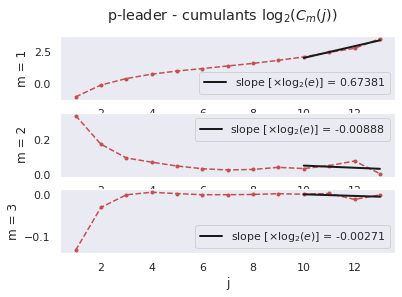

In [37]:
mfa2.plot_cumulants()

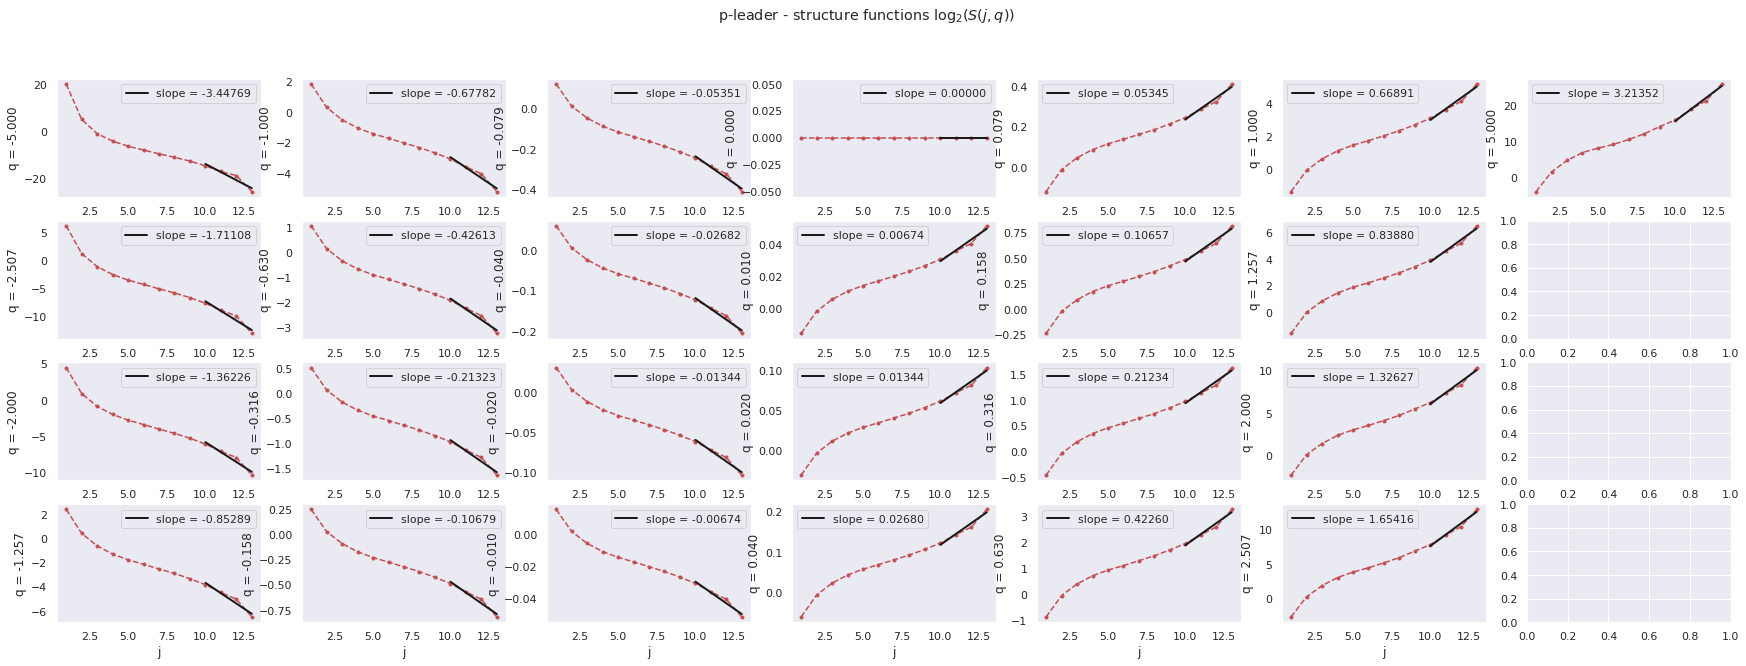

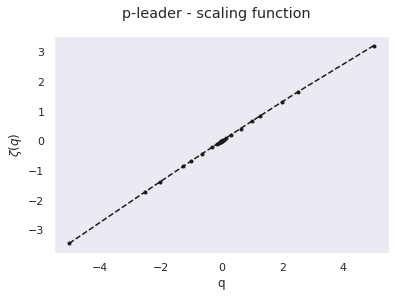

In [38]:
mfa2.plot_structure()

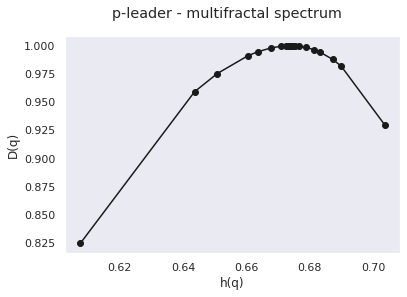

In [39]:
mfa2.plot_spectrum()

Comparing the multifractal spectre

In [ ]:
D_matlab = np.genfromtxt(fname="MATLAB_values/D_LWT.tsv", delimiter="\t", skip_header=0, filling_values=1)
h_matlab = np.genfromtxt(fname="MATLAB_values/h_LWT.tsv", delimiter="\t", skip_header=0, filling_values=1)

In [ ]:
h_python = mfa2.spectrum.hq
D_python = mfa2.spectrum.Dq

In [ ]:
plt.plot(h_python, D_python)
plt.plot(h_matlab, D_matlab)
plt.legend(['python','matlab'])
plt.xlabel('h')
plt.ylabel('D(h)')
plt.show()

In [ ]:
(np.abs(D_python - D_matlab) < 1e-12).all()

# Wavelet leader version (p = $+\infty$)

In [40]:
l = np.logspace(np.log10(0.01), np.log10(5), 10)
q = np.array([*-l, *l, 0, 1, 2, -1, -2])
q.sort()

In [41]:
mfa3 = mf.MFA(
    wt_name=f'db{nwt}',
    formalism='wlmf',
    j1=10,j2=14,
    q=q,
    n_cumul=3,
    gamint=1/2,
    wtype=0
)

In [42]:
mfa3.analyze(data)

 
(!) Warning: Value of j2 is higher than the maximum            allowed level. Max level and j2 set to 13
 


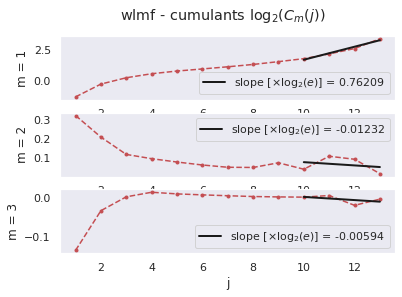

In [43]:
mfa3.plot_cumulants()

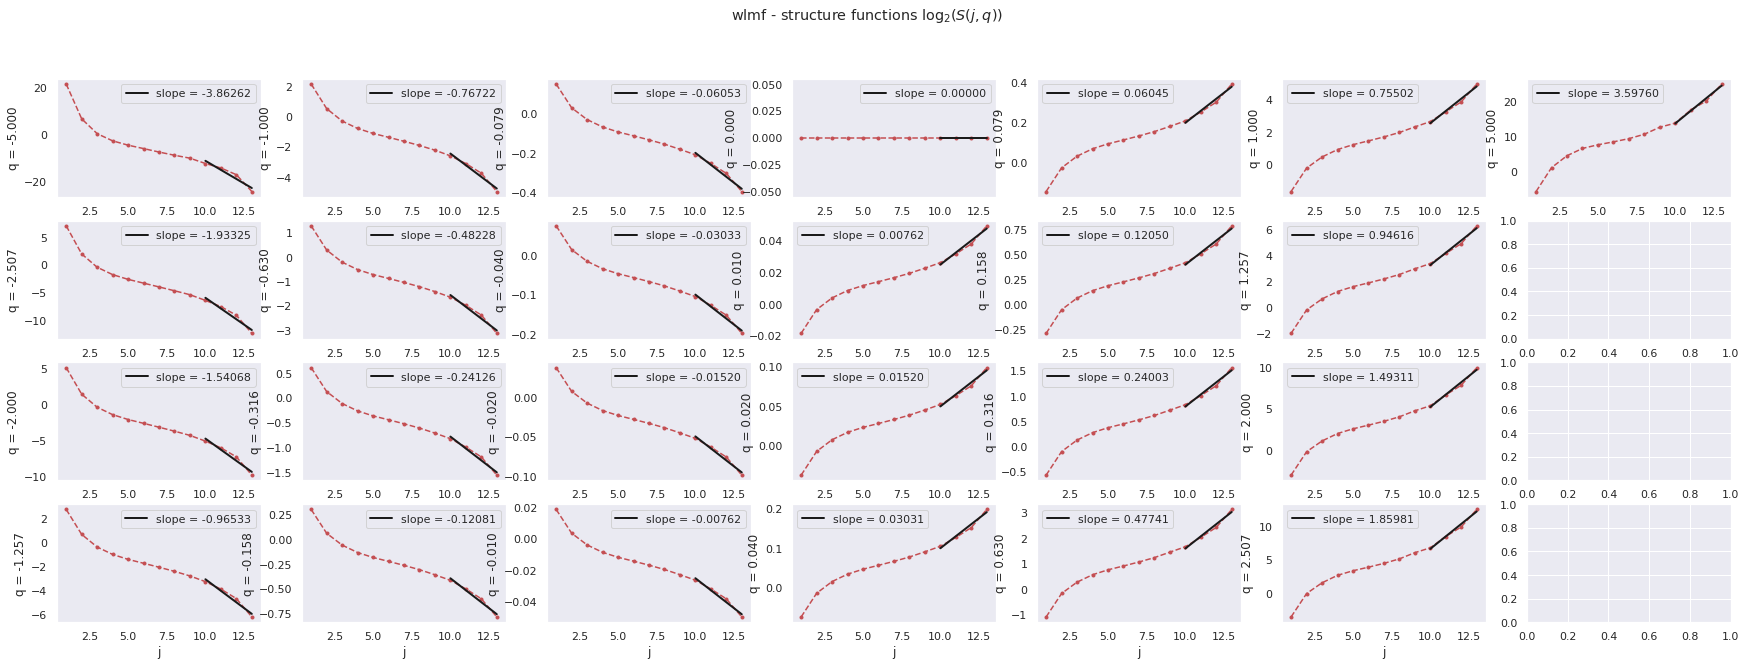

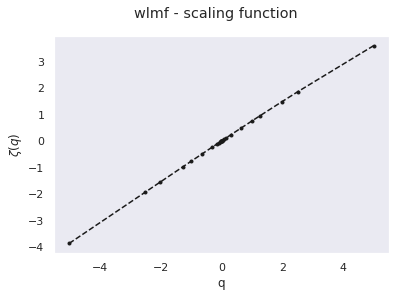

In [44]:
mfa3.plot_structure()

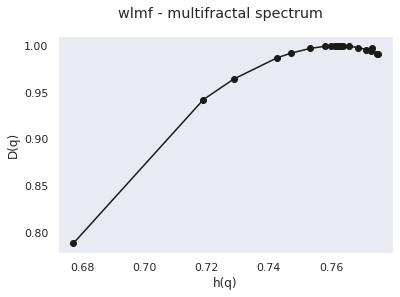

In [45]:
mfa3.plot_spectrum()

Comparing the MATLAB and python values for $\zeta(q)$

The values are found in `est.LWT.t`